In [243]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [244]:
from src.data_loader import *
import seaborn as sn
import matplotlib.pyplot as plt

parser = htmlParser()
parser.load_pickle()

# Section 1: some interesting results or statistics about the raw data

"complete all the necessary descriptive statistics tasks"
"show us that you have clear project goals"

- That you can handle the data in its size.
- That you understand what’s in the data (formats, distributions, missing values, correlations, etc.).
- That you considered ways to enrich, filter, transform the data according to your needs.
- That you have a reasonable plan and ideas for methods you’re going to use, giving their essential mathematical details in the notebook.
- That your plan for analysis and communication is reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.

In [245]:
df_article_names = read_articles()
df_html_stats = parser.get_df_html_stats()
df_categories = read_categories()
df_links = read_links()
df_shortest_path = read_shortest_path_matrix()
df_unfinished = read_unfinished_paths() # check if only valid articles appear in paths!
df_finished = read_finished_paths() 
df_sm = read_similartiy_matrix()

In [246]:
# weirdly, some targets do not correspond to valid articles (e.g. Long peper or Christmas). Let's remove them
df_unfinished = df_unfinished.loc[df_unfinished['target'].isin(df_article_names), :].reset_index()

In [260]:
# let's add some useful metrics to each paths dataframe: shortest path, semantic similarity 
df_unfinished['cosine_similarity'] = df_unfinished.apply(lambda x: find_shortest_distance(x, df_sm), axis=1)
df_unfinished['shortest_path'] = df_unfinished.apply(lambda x: find_shortest_distance(x, df_shortest_path), axis=1)
df_unfinished['path_length'] = df_unfinished['path'].apply(lambda x: x.count(';') + 1)
df_unfinished['back_clicks'] = df_unfinished['path'].apply(lambda x: x.count('<'))

df_finished['cosine_similarity'] = df_finished.apply(lambda x: find_shortest_distance(x, df_sm), axis=1)
df_finished['shortest_path'] = df_finished.apply(lambda x: find_shortest_distance(x, df_shortest_path), axis=1)
df_finished['path_length'] = df_finished['path'].apply(lambda x: x.count(';') + 1)
df_finished['back_clicks'] = df_finished['path'].apply(lambda x: x.count('<'))

In [261]:
# LE MYSTÈRE DU SIÈCLE: HOW COULD THIS HAPPEN?? Un chemin impossible dans les finished paths 🤔 
df_finished[df_finished['shortest_path']==-1] # ligne 2145 dans paths_finished

,hashedIpAddress,timestamp,durationInSec,path,rating,cosine similarity,shortest_path,path_length,back_clicks,cosine_similarity
2395,5f22535607b1d77d,2012-11-26 16:03:08,3,Bird;Wikipedia Text of the GNU Free Documentat...,NaN,0.332693,-1,2,0,0.332693


In [262]:
# Le chemin n'est pas complet, bizarre. Rien de suspect pourtant dans les données. Not doing anything fancy with the data too...
# Also, I'm quite sure that there is no link from Bird to whatever that second atrocity of an article is
# Anyway, this path is clearly wrong and we should remove it but why doesn't it at least load properly?
df_finished.iloc[2395]['path']

'Bird;Wikipedia Text of the GNU Free Documentation License'

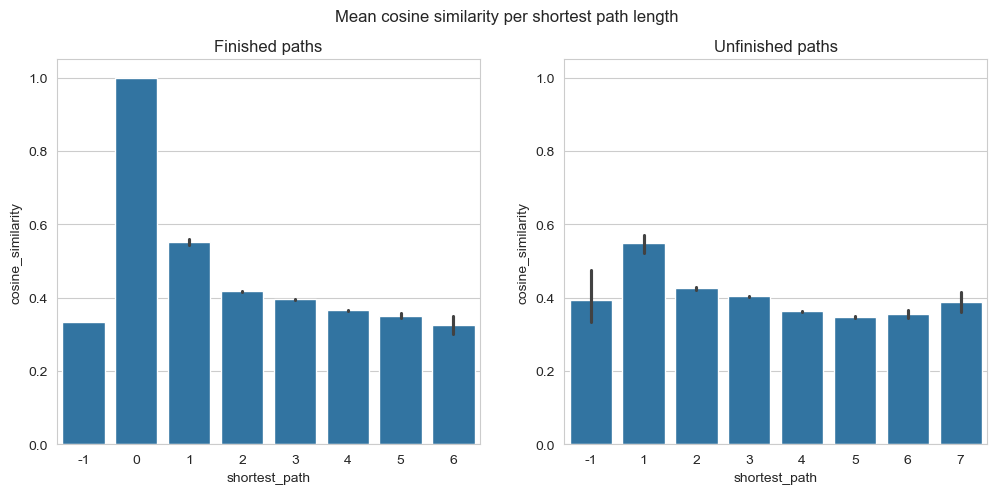

In [263]:
# note: -1 with no errorbar makes no sense. 1 with no error bar makes sense (trivial case where start=target and similarity with itself=1)
# impossible paths in unfinishes paths are possible however. check if it is sound though because of the previous problem.

plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
sn.barplot(data=df_finished, x='shortest_path', y='cosine_similarity')
plt.title('Finished paths')

plt.subplot(122, sharey=ax)
sn.barplot(data=df_unfinished, x='shortest_path', y='cosine_similarity')
plt.title('Unfinished paths')

plt.suptitle('Mean cosine similarity per shortest path length')
plt.show()

In [267]:
from scipy.stats import pearsonr, spearmanr

def calculate_correlations(df):
    # Exclude 'Unreachable' paths
    df_filtered = df[df['shortest_path'] != -1].copy()

    # Ensure 'shortest_path' is numeric
    df_filtered['shortest_path'] = df_filtered['shortest_path'].astype(float)

    pearson_corr, pearson_p = pearsonr(df_filtered['shortest_path'], df_filtered['cosine_similarity'])
    spearman_corr, spearman_p = spearmanr(df_filtered['shortest_path'], df_filtered['cosine_similarity'])

    # Print results
    print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4e}")
    print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4e}")

print('Finished paths:')
finished_results = calculate_correlations(df_finished)
print('\nUnfinished paths:')
unfinished_results = calculate_correlations(df_unfinished)

Finished paths:
Pearson correlation: -0.2874, p-value: 0.0000e+00
Spearman correlation: -0.2359, p-value: 0.0000e+00

Unfinished paths:
Pearson correlation: -0.2759, p-value: 0.0000e+00
Spearman correlation: -0.2769, p-value: 0.0000e+00


- Pearson Correlation
Measures the linear relationship between two continuous variables.

- Spearman Correlation
Assesses the monotonic relationship using ranked data, making it less sensitive to outliers and non-linear relationships.

The p-values are effectively zero, which is highly significant statistically. This suggests that the observed correlations are unlikely to be due to random chance.

-> Thus as the distance path increase, the cosine_similarity decrease
In other words...

### Difficulty measure
Find patterns in user behaviour and try to understand how we could measure whether a game was difficult or not

The mean duration of finished paths is 158 seconds
The mean duration of unfinished paths is 836 seconds


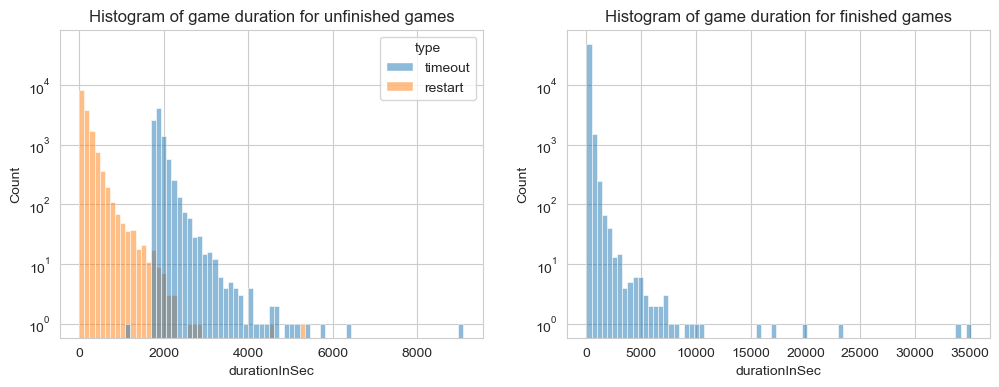

In [253]:
# REMOVE OUTLIERS THAT MAKE NO SENSE

#df_game_durations = pd.concat([df_finished[['durationInSec', 'type']], df_unfinished[['durationInSec', 'type']]], ignore_index=True)
print(f"The mean duration of finished paths is {df_finished['durationInSec'].mean():.0f} seconds")
print(f"The mean duration of unfinished paths is {df_unfinished['durationInSec'].mean():.0f} seconds")

plt.figure(figsize=(12, 4))
ax1 = plt.subplot(121)
sn.histplot(df_unfinished, x='durationInSec', hue='type', bins=75)
plt.yscale('log')
plt.title('Histogram of game duration for unfinished games')

plt.subplot(122, sharey = ax1)
sn.histplot(df_finished, x='durationInSec', bins=75, alpha=0.5)
plt.yscale('log')
plt.title('Histogram of game duration for finished games')
plt.show()

In [254]:
sorted = df_unfinished[df_unfinished['type']=='timeout']['durationInSec'].sort_values()
sorted

13393    1129
12397    1768
3960     1777
6747     1778
1287     1784
         ... 
7093     5188
19244    5360
21610    5716
2815     6413
4242     9089
Name: durationInSec, Length: 9317, dtype: int64

In [255]:
sorted = df_finished['durationInSec'].sort_values(ascending=False)
sorted

10855    35091
49073    34009
23509    23326
23023    19740
43583    17171
         ...  
24326        0
33832        0
20919        0
50466        0
5857         0
Name: durationInSec, Length: 51318, dtype: int64

Text(0.5, 1.04, 'Path duration by rating')

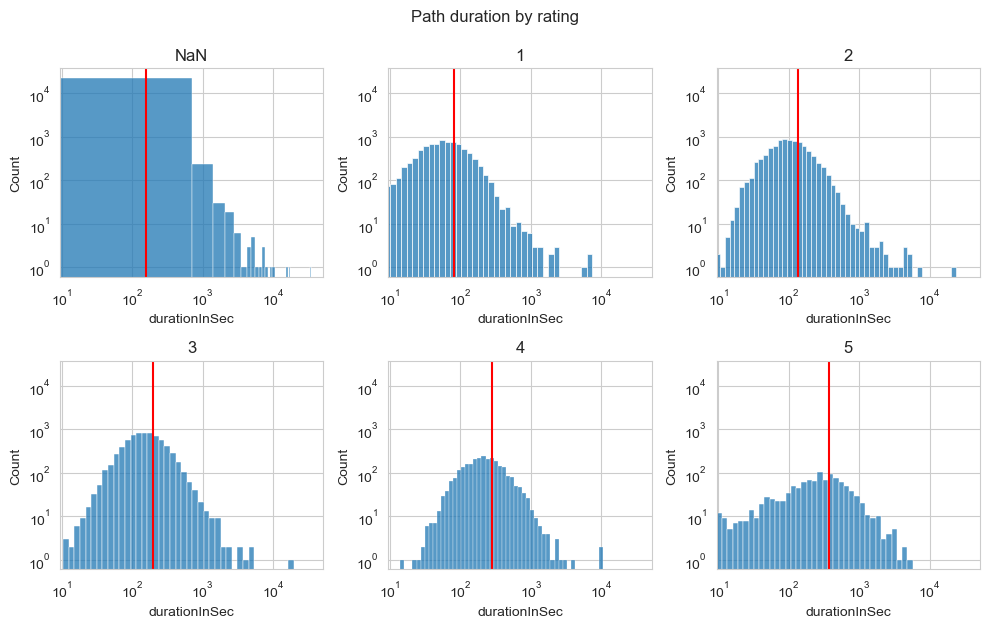

In [256]:
# Those are some nice log-normal distributions

plt.figure(figsize=(10, 6))

ax1 = plt.subplot(231)
sn.histplot(df_finished[df_finished['rating'].isnull()], x='durationInSec', bins=50) # change x to x = 'path_length' for path length
plt.axvline(df_finished[df_finished['rating'].isnull()]['durationInSec'].mean(), color='red')
plt.yscale('log')
plt.xscale('log')
plt.title('NaN')


for i in range(1, 6):
    plt.subplot(231+i, sharex = ax1, sharey=ax1)
    sn.histplot(df_finished[df_finished['rating']==i], x='durationInSec', bins=50)
    plt.axvline(df_finished[df_finished['rating']==i]['durationInSec'].mean(), color='red')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(i)

plt.tight_layout()
plt.suptitle('Path duration by rating', y=1.04)

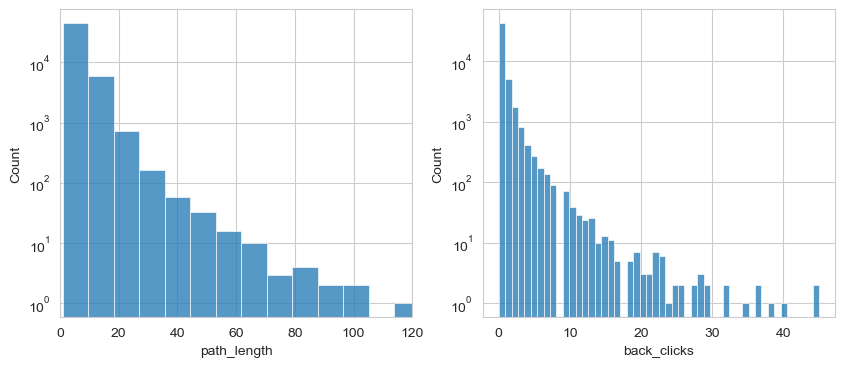

In [257]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
sn.histplot(df_finished, x='path_length', bins=50)
plt.yscale('log')
plt.xlim(0, 120)

plt.subplot(122)
sn.histplot(df_finished, x='back_clicks', bins=50)
plt.yscale('log')